In [512]:
# Imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [513]:
# Read GIS data
roads = gpd.read_file('data/GIS/2261_ulice_egib_wfs_gml.gml')
plots = gpd.read_file('data/GIS/2261_dzialki_egib_wfs_gml.gml')
buildings = gpd.read_file('data/GIS/budynki_2022.gpkg')

# Get our site geometry
site_gml_id = 'dzialki.490123'
site = plots[plots['gml_id'] == site_gml_id]
site.to_crs(epsg=2177)

,gml_id,coordinates,ID_DZIALKI,NUMER_DZIALKI,NAZWA_OBREBU,NUMER_OBREBU,NUMER_JEDNOSTKI,NAZWA_GMINY,GRUPA_REJESTROWA,DATA,geometry
55603,dzialki.490123,"6536098.100000,6023717.530000 6536155.140000,6...",226101_1.0049.222/4,222/4,Jasień,49,01_1,M.Gdańsk,7,2024-10-15 21:30:16,"POLYGON ((6536098.1 6023728.68, 6536108.37 602..."


In [514]:
site_geom = site.geometry.iloc[0]
neighbors = plots[plots.geometry.touches(site_geom)]
print("Site has", neighbors.shape[0], "neighboring plots")


Site has 10 neighboring plots


In [515]:
# Find public road neighbors
public_neighbors = neighbors[neighbors['GRUPA_REJESTROWA'].isin([1, 4])]

# Find which public plots intersect with roads
public_road_neighbors = gpd.sjoin(public_neighbors, roads, how='inner', predicate='intersects', lsuffix='neighbor', rsuffix='road')
print("Site has access from", public_road_neighbors.shape[0], "public road(s)")

def get_road_side(plot_geom, road_geom, buffer_distance=0.1):
    """Get the road-facing side of a plot."""
    # Create a buffer around the road
    road_buffer = road_geom.buffer(buffer_distance)
    # Get the plot boundary
    plot_boundary = plot_geom.boundary
    # Find the intersection with the road buffer
    road_side = plot_boundary.intersection(road_buffer)
    return road_side

# Get road sides for each public road
site_road_sides = []
for idx, road in public_road_neighbors.iterrows():
    road_side = get_road_side(site_geom, road.geometry)
    if not road_side.is_empty:
        site_road_sides.append({
            'road_id': idx,
            'road_side': road_side,
            'road_name': road['nazwa_ulicy']
        })

# Find the primary road (with longest frontage)
road_lengths = [(info['road_id'], info['road_side'].length) for info in site_road_sides]
primary_road_id = max(road_lengths, key=lambda x: x[1])[0]
primary_road = public_road_neighbors.loc[primary_road_id]
primary_road_side = next(info['road_side'] for info in site_road_sides if info['road_id'] == primary_road_id)

Site has access from 1 public road(s)


Park im. ks. Bronisława Kabata is the primary access road with the longest frontage
Site frontage length: 34.05m
Analysis radius: 102.15m


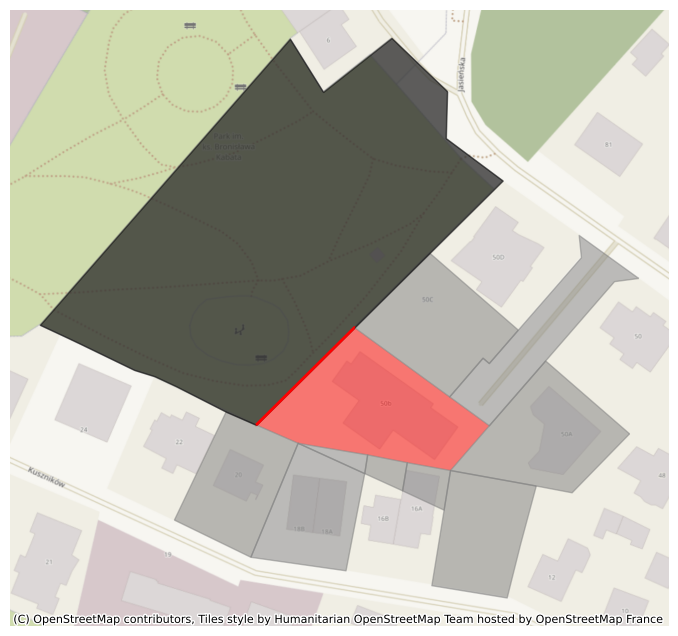

,gml_id_neighbor,coordinates_neighbor,ID_DZIALKI,NUMER_DZIALKI,NAZWA_OBREBU,NUMER_OBREBU,NUMER_JEDNOSTKI,NAZWA_GMINY,GRUPA_REJESTROWA,DATA,...,gml_id_road,coordinates_road,nazwa_gminy,id_gminy,nazwa_miejscowosci,id_miejscowosci,nazwa_ulicy,id_ulicy,data_uchwaly,nr_uchwaly
64195,dzialki.403950,"6536045.210000,6023728.680000 6536158.410000,6...",226101_1.0049.104,104,Jasień,49,01_1,M.Gdańsk,4,2024-10-15 21:30:16,...,ulice.80dc9338-9b50-4b89-a06d-2f10b51aa086,"6536004.980000,6023728.680000 6536156.510000,6...",Gdańsk,226101_1,Gdańsk,933016,Park im. ks. Bronisława Kabata,48641,2015-06-03 00:00:00,IX/193/15


In [516]:

# Calculate frontage length and analysis radius
primary_road_side_length = primary_road_side.length
analysis_radius = max(50, min(3 * primary_road_side_length, 200))

print(f"{primary_road['nazwa_ulicy']} is the primary access road with the longest frontage")
print(f"Site frontage length: {primary_road_side_length:.2f}m")
print(f"Analysis radius: {analysis_radius:.2f}m")

fig, ax = plt.subplots(figsize=(12, 8))
site.plot(ax=ax, color='red', alpha=0.5, label='Site')
neighbors.plot(ax=ax, color='gray', edgecolor='gray', alpha=0.5, label='Neighbors')
gpd.GeoSeries(primary_road.geometry).plot(ax=ax, color='black', edgecolor='black', alpha=0.5, label='Primary Road')
gpd.GeoSeries(primary_road_side).plot(ax=ax, color='red', linewidth=2, label='Primary Road Side')
ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()
plt.show()
public_road_neighbors

In [517]:
# Find built-up neighbors on the same road
buildings['centroid'] = buildings.centroid
building_centroids = buildings.set_geometry('centroid', inplace=False).set_crs(epsg=2177)

In [518]:
built_up_neighbors = gpd.sjoin(neighbors, building_centroids, how='inner', predicate='intersects', lsuffix='neighbors', rsuffix='building')
built_up_neighbors_on_the_same_road = built_up_neighbors[built_up_neighbors.geometry.touches(primary_road.geometry)]
number_of_built_up_neighbors_on_the_same_road = built_up_neighbors_on_the_same_road['gml_id'].nunique()
print("Site has", number_of_built_up_neighbors_on_the_same_road, "built-up neighboring plots on the same access road")

Site has 2 built-up neighboring plots on the same access road


In [519]:
def get_setback(buildings, road_side):
    """Get the setback distance from a plot to a road."""
    setback = buildings.distance(road_side).min()
    return setback

if number_of_built_up_neighbors_on_the_same_road > 0:
    setbacks = []
    # Get unique neighbor plots
    unique_neighbors = built_up_neighbors_on_the_same_road.drop_duplicates(subset='gml_id')
    
    for idx, plot in unique_neighbors.iterrows():
        # Get all buildings on this plot
        buildings_on_plot = buildings[buildings['GID'].isin(
            built_up_neighbors_on_the_same_road[
                built_up_neighbors_on_the_same_road['gml_id'] == plot['gml_id']
            ]['GID']
        )]
        
        
        if not buildings_on_plot.empty:
            # Get the road side for this plot
            road_side = get_road_side(plot.geometry, primary_road.geometry)
            
            # Calculate minimum setback for this plot
            setback = get_setback(buildings_on_plot.geometry, road_side)
            setbacks.append({
                'plot_id': plot['gml_id'],
                'setback': setback
            })
        else:
            setbacks.append({
                'plot_id': plot['gml_id'],
                'setback': 0
            })

    # Get the maximum setback from all neighbors
    max_setback = max(s['setback'] for s in setbacks)
    
    # Print individual setbacks for verification
    print("\nSetbacks by plot:")
    for s in setbacks:
        print(f"{s['plot_id']}: {s['setback']:.2f}m")
    print(f"\nRequired setback: {max_setback:.2f}m")
    
else:
    max_setback = 0
    print("No built-up neighbors on the same road, so no setback is required")


Setbacks by plot:
dzialki.361500: 5.11m
dzialki.282984: 8.06m

Required setback: 8.06m


In [520]:
# offset roadside to get setback line
primary_road = gpd.GeoSeries(primary_road.geometry)
primary_road.set_crs(epsg=2177, inplace=True)
setback_buffer = primary_road.buffer(max_setback)

site_and_neighbors = pd.concat([site, built_up_neighbors_on_the_same_road]).union_all()
setback = setback_buffer.intersection(site_and_neighbors)

/var/folders/j5/0qh0dgj5607fhs9231nrxjww0000gn/T/ipykernel_44894/2798484132.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


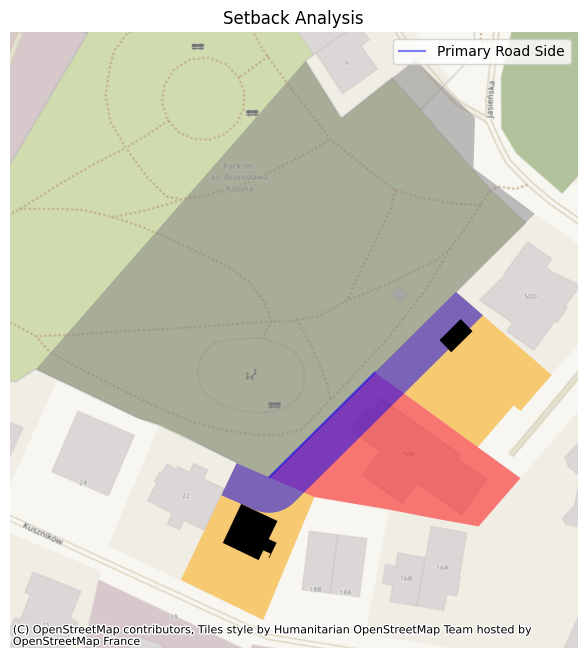

In [521]:
# Plot primary road, primary road side, site, built-up neighbors on the same road

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the primary road plot
gpd.GeoSeries(primary_road.geometry).plot(ax=ax, color='gray', alpha=0.5, label='Primary Road')

# Plot the built-up neighbors on the same road
built_up_neighbors_on_the_same_road.plot(ax=ax, color='orange', alpha=0.5, label='Built-up Plots on the Same Road')

# Plot the site
site.plot(ax=ax, color='red', alpha=0.5, label='Site')

# Plot the setback
setback.plot(ax=ax, color='blue', alpha=0.5, label='Setback')

# Plot the buildings on neighbors
buildings[buildings['GID'].isin(built_up_neighbors_on_the_same_road['GID'])].plot(ax=ax, color='black', label='Buildings on Plots')

# Plot the primary road side
gpd.GeoSeries(primary_road_side).plot(ax=ax, color='blue', alpha=0.5, label='Primary Road Side')

ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()

plt.title('Setback Analysis')
plt.legend()





Number of plots 92160
Analysis area has 41 built-up plots


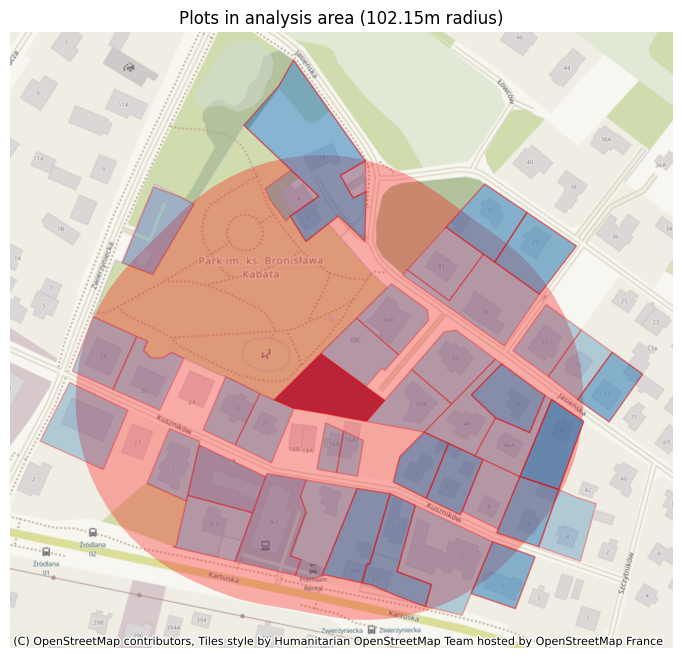

In [522]:
analysis_area = site_geom.buffer(analysis_radius)
print("Number of plots", plots.shape[0])
plots_in_analysis_area = plots[plots.geometry.intersects(analysis_area)]
built_up_plots_in_analysis_area = gpd.sjoin(plots_in_analysis_area, building_centroids, how='inner', predicate='intersects', lsuffix='analysisplot', rsuffix='building')
number_of_built_up_plots_in_analysis_area = built_up_plots_in_analysis_area['gml_id'].nunique()
print("Analysis area has", number_of_built_up_plots_in_analysis_area, "built-up plots")


# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
site.plot(ax=ax, color='red', label='Site')
gpd.GeoSeries(analysis_area).plot(ax=ax, color='red', alpha=0.3, label='Analysis Area')
built_up_plots_in_analysis_area.plot(ax=ax, edgecolor='red', alpha=0.3, label='Analysis Plots')
ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()
plt.title(f"Plots in analysis area ({analysis_radius:.2f}m radius)")
plt.show()

In [523]:
buildings.head()

,OBJECTID,GID,FUNKCJA,LICZBA_KONDYGNACJI,WYSOKOSC,Shape.STArea(),Shape.STLength(),geometry,centroid
0,1,113862,budynki mieszkalne,2,7.2,199.53790,63.214485,"MULTIPOLYGON (((6532776.22 6023644.78, 6532774...",POINT (6532769.048 6023637.236)
1,2,113868,budynki mieszkalne,2,7.2,108.30720,42.499125,"MULTIPOLYGON (((6532799.04 6023594.35, 6532795...",POINT (6532792.863 6023590.389)
2,3,113871,budynki mieszkalne,2,7.2,126.81275,46.701703,"MULTIPOLYGON (((6532813.43 6023417.04, 6532811...",POINT (6532806.728 6023414.925)
3,4,113874,budynki mieszkalne,2,7.2,134.29270,48.052114,"MULTIPOLYGON (((6532827.23 6023445.23, 6532824...",POINT (6532819.114 6023441.268)
4,5,114075,budynki mieszkalne,2,7.2,95.13545,40.288156,"MULTIPOLYGON (((6533177.35 6023024.54, 6533173...",POINT (6533171.512 6023020.926)


In [524]:
from shapely.geometry import Point, LineString

def extend_line(line, distance=100):
    """Extend a LineString in both directions."""
    # Get coordinates of the line
    coords = list(line.coords)
    
    # Get the first and last points
    p1 = Point(coords[0])
    p2 = Point(coords[-1])
    
    # Get the vector of the line
    vector = [(p2.x - p1.x), (p2.y - p1.y)]
    
    # Normalize the vector
    length = (vector[0]**2 + vector[1]**2)**0.5
    unit_vector = [v/length for v in vector]
    
    # Create new start and end points
    new_start = (
        p1.x - unit_vector[0] * distance,
        p1.y - unit_vector[1] * distance
    )
    new_end = (
        p2.x + unit_vector[0] * distance,
        p2.y + unit_vector[1] * distance
    )
    
    return LineString([new_start, coords[0], coords[-1], new_end])

def get_building_front_width(building_geom, road_side):
    """Get the width of building front by projecting onto road side line."""
    if road_side.length < 10:
        extended_road_side = extend_line(road_side) 
    else:
        extended_road_side = road_side
    
    # Get all vertices of the building polygon
    vertices = list(building_geom.exterior.coords)
    
    # Project each vertex onto the extended road side
    projections = [extended_road_side.project(Point(vertex)) for vertex in vertices]
    
    # Get the min and max projections to find the extent
    min_proj = min(projections)
    max_proj = max(projections)

    # Get the points on the extended road side
    point_start = extended_road_side.interpolate(min_proj)
    point_end = extended_road_side.interpolate(max_proj)

    
    # Create a line between these points
    projected_width = LineString([point_start, point_end])
    return projected_width.length


In [525]:

"""
§ 7. 

1.  Wysokość zabudowy ustala się na podstawie wysokości zabudowy na dostępnych z tej samej drogi publicznej
    przylegających działkach sąsiednich.

2.  Jeżeli wysokość, o której mowa w ust. 1, na działkach, o których mowa w ust. 1, przebiega tworząc uskok,
    wówczas przyjmuje się jej średnią wielkość występującą na tych działkach.

"""

# Calculate plot metrics
plot_metrics = []
for plot_id in built_up_plots_in_analysis_area['gml_id'].unique():
    # Get the plot
    plot = built_up_plots_in_analysis_area[built_up_plots_in_analysis_area['gml_id'] == plot_id]
    plot_area = plot.geometry.iloc[0].area
    
    # Get all buildings on this plot
    plot_buildings = buildings[buildings['GID'].isin(
        built_up_plots_in_analysis_area[
            built_up_plots_in_analysis_area['gml_id'] == plot_id
        ]['GID']
    )]
    # Calculate total building footprint
    total_buildings_footprint = plot_buildings.geometry.area.sum()

    # Calculate gross floor area of each building and sum them up
    building_footprint = plot_buildings.geometry.area
    floors = plot_buildings['LICZBA_KONDYGNACJI']
    gross_floor_area = building_footprint * floors
    total_gross_floor_area = gross_floor_area.sum()

    # Calculate floor area ratio
    floor_area_ratio = total_gross_floor_area / plot_area
    
    # Get the tallest building on the plot
    building_height = plot_buildings['WYSOKOSC'].max()

    # Get the front width of the largest building on the neighbours on the same road
    if plot_id in built_up_neighbors_on_the_same_road['gml_id'].unique():
        largest_building = plot_buildings[plot_buildings.geometry.area == plot_buildings.geometry.area.max()].union_all()
        front_width = get_building_front_width(largest_building, primary_road_side)
        print("Front width:", front_width)
    else:
        print(plot_id, "is not a neighbor on the same road")
        front_width = None

    # Calculate coverage ratio
    coverage_ratio = total_buildings_footprint / plot_area
    if coverage_ratio < 0.01:
        continue

    plot_metrics.append({
        'plot_id': plot_id,
        'plot_area': plot_area,
        'building_area': total_buildings_footprint,
        'coverage_ratio': coverage_ratio,
        'floor_area_ratio': floor_area_ratio,
        'building_height': building_height,
        'front_width': front_width
    })

# Convert to DataFrame for analysis
plot_metrics_df = pd.DataFrame(plot_metrics)

dzialki.438924 is not a neighbor on the same road
dzialki.85192 is not a neighbor on the same road
dzialki.83927 is not a neighbor on the same road
dzialki.87757 is not a neighbor on the same road
dzialki.527299 is not a neighbor on the same road
dzialki.218973 is not a neighbor on the same road
dzialki.275235 is not a neighbor on the same road
dzialki.361031 is not a neighbor on the same road
dzialki.87896 is not a neighbor on the same road
dzialki.251196 is not a neighbor on the same road
dzialki.83898 is not a neighbor on the same road
dzialki.361170 is not a neighbor on the same road
dzialki.361116 is not a neighbor on the same road
dzialki.361501 is not a neighbor on the same road
dzialki.440603 is not a neighbor on the same road
Front width: 0.0
dzialki.503000 is not a neighbor on the same road
dzialki.84618 is not a neighbor on the same road
dzialki.87399 is not a neighbor on the same road
dzialki.361030 is not a neighbor on the same road
dzialki.203147 is not a neighbor on the 

In [526]:
plot_metrics_df

,plot_id,plot_area,building_area,coverage_ratio,floor_area_ratio,building_height,front_width
0,dzialki.438924,1241.18230,480.86420,0.387424,0.774849,7.2,NaN
1,dzialki.85192,556.89080,146.48115,0.263034,0.473166,7.2,NaN
2,dzialki.83927,812.67185,122.74205,0.151035,0.248340,7.2,NaN
3,dzialki.87757,579.93090,117.09115,0.201905,0.605716,10.3,NaN
4,dzialki.527299,1257.86255,227.96745,0.181234,0.362468,7.2,NaN
5,dzialki.218973,602.09455,245.76770,0.408188,1.632752,13.4,NaN
6,dzialki.275235,560.52335,161.37870,0.287907,0.863722,10.3,NaN
7,dzialki.361031,231.99475,79.81390,0.344033,1.032100,10.3,NaN
8,dzialki.87896,598.13230,112.78445,0.188561,0.318444,7.2,NaN
9,dzialki.251196,724.35585,126.54410,0.174699,0.316576,7.2,NaN


In [527]:
# Zoning conditions coverage ratio from min to mean+20%
zoning_coverage_ratio_min = float(plot_metrics_df['coverage_ratio'].min())
zoning_coverage_ratio_max = float(plot_metrics_df['coverage_ratio'].mean() * 1.2)
zoning_floor_area_ratio = float(plot_metrics_df['floor_area_ratio'].mean() * 1.2)

# Zoning height 
neighbour_ids = built_up_neighbors_on_the_same_road['gml_id'].unique()
neighbour_heights = plot_metrics_df[plot_metrics_df['plot_id'].isin(neighbour_ids)]['building_height']

zoning_height = (neighbour_heights).mean()

# Zoning front width
zoning_front_width = float(plot_metrics_df['front_width'].mean() * 1.2)


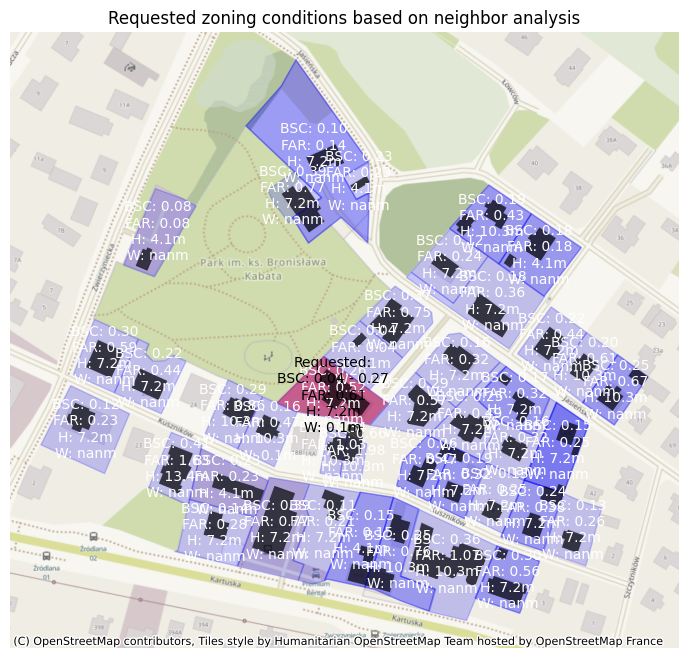

In [528]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Plot base layers
site.plot(ax=ax, color='red', alpha=0.5, label='Site')

# Plot built-up plots with color based on coverage ratio
for _, metrics in plot_metrics_df.iterrows():
    plot = built_up_plots_in_analysis_area[built_up_plots_in_analysis_area['gml_id'] == metrics['plot_id']]
    plot_buildings = buildings[buildings['GID'].isin(
        built_up_plots_in_analysis_area[
            built_up_plots_in_analysis_area['gml_id'] == metrics['plot_id']
        ]['GID']
    )]
    
    # Plot the plot and its buildings
    plot.plot(ax=ax, color='blue', edgecolor='blue', alpha=0.2)
    plot_buildings.plot(ax=ax, color='black', alpha=0.7)
    
    # Add coverage ratio annotation
    centroid = plot.geometry.iloc[0].centroid
    ax.annotate(f"BSC: {metrics['coverage_ratio']:.2f}\nFAR: {metrics['floor_area_ratio']:.2f}\nH: {metrics['building_height']:.1f}m\nW: {metrics['front_width']:.1f}m", 
                xy=(centroid.x, centroid.y),
                xytext=(0, 0), textcoords='offset points',
                ha='center', va='center', color='white')

# Plot zoning coverage ratios on site centroid
site_centroid = site.geometry.union_all().centroid
ax.annotate(f"Requested:\nBSC: {zoning_coverage_ratio_min:.2f} - {zoning_coverage_ratio_max:.2f}\nFAR: {zoning_floor_area_ratio:.2f}\nH: {zoning_height:.1f}m\nW: {zoning_front_width:.1f}m", 
            xy=(site_centroid.x, site_centroid.y), 
            ha='center', va='center', color='black')

ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()
plt.title(f'Requested zoning conditions based on neighbor analysis')
plt.show()
